# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

---
<a id="part1"></a>
## Part 1. Data Exploration

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
%matplotlib inline

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup  
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.layers.convolutional import Convolution1D
from keras.layers.embeddings import Embedding

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data

In [ ]:
# Load csv file
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


### Data Exploration

In [ ]:
print ("The shape of the  data is (row, column):"+ str(df.shape))
print (df.info())

The shape of the  data is (row, column):(51449, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51449 entries, 0 to 51448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  51449 non-null  object 
 1   Brand Name    42266 non-null  object 
 2   Price         49835 non-null  float64
 3   Rating        51449 non-null  int64  
 4   Reviews       51435 non-null  object 
 5   Review Votes  49826 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.4+ MB
None


In [ ]:
#Checking for null values
df.isnull().sum()

Product Name       0
Brand Name      9183
Price           1614
Rating             0
Reviews           14
Review Votes    1623
dtype: int64

In [ ]:
df.describe()

,Price,Rating,Review Votes
count,49835.000000,51449.000000,49826.000000
mean,181.287571,3.768781,1.461887
std,120.507864,1.622430,8.235581
min,17.950000,1.000000,0.000000
25%,109.990000,2.000000,0.000000
50%,149.990000,5.000000,0.000000
75%,224.770000,5.000000,1.000000
max,2000.000000,5.000000,366.000000


In [ ]:
print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))


Total number of reviews:  51449

Total number of brands:  37

Total number of unique products:  302

Percentage of reviews with neutral sentiment : 6.28%

Percentage of reviews with positive sentiment : 67.77%

Percentage of reviews with negative sentiment : 25.92%


### Data Visualization 

Text(0, 0.5, 'Count')

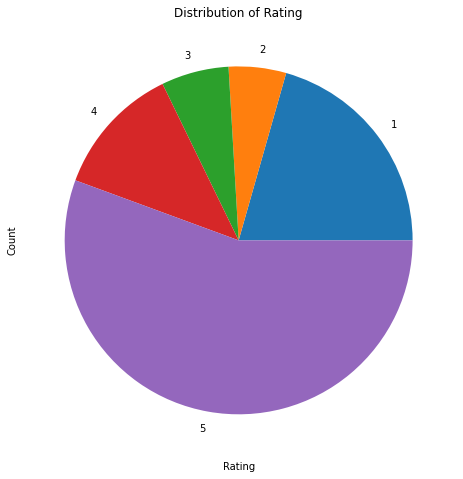

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='pie')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

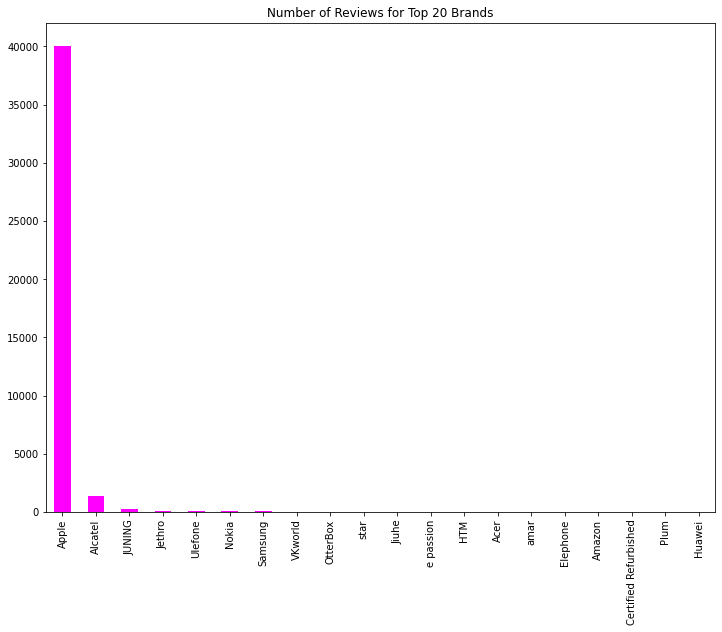

In [ ]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,9))
brands[:20].plot(kind='bar',color="magenta")
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

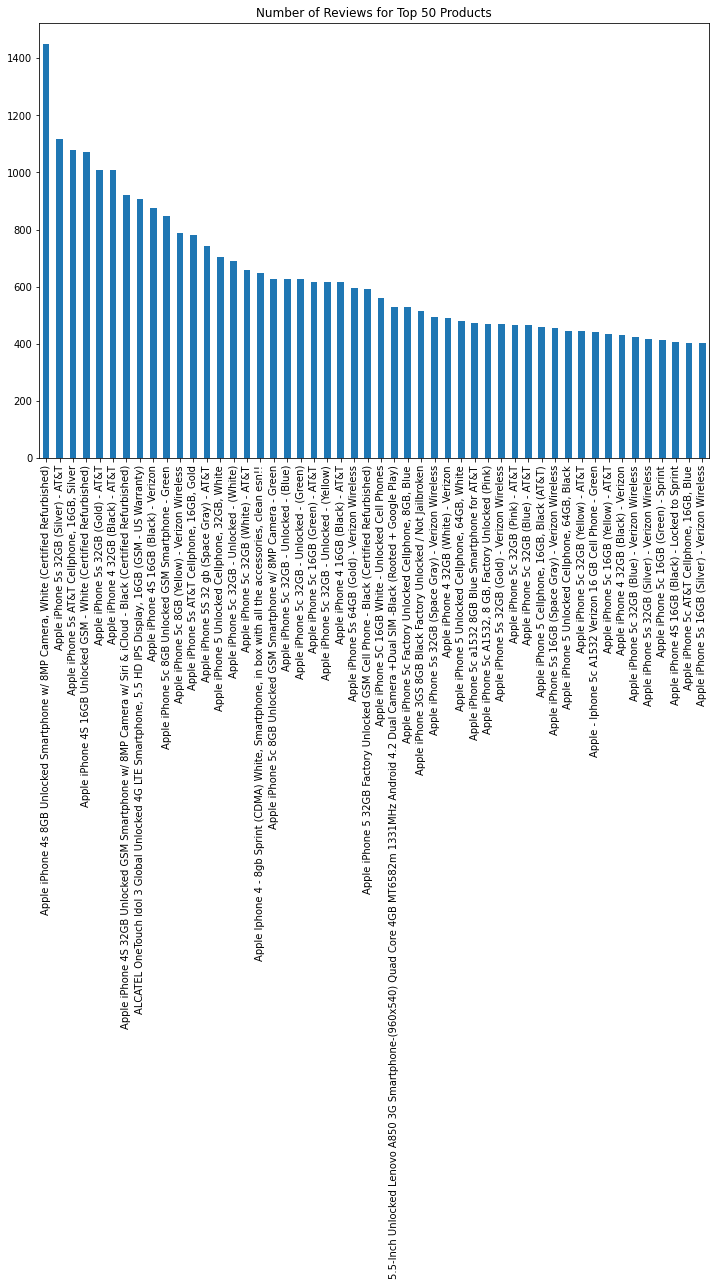

In [ ]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

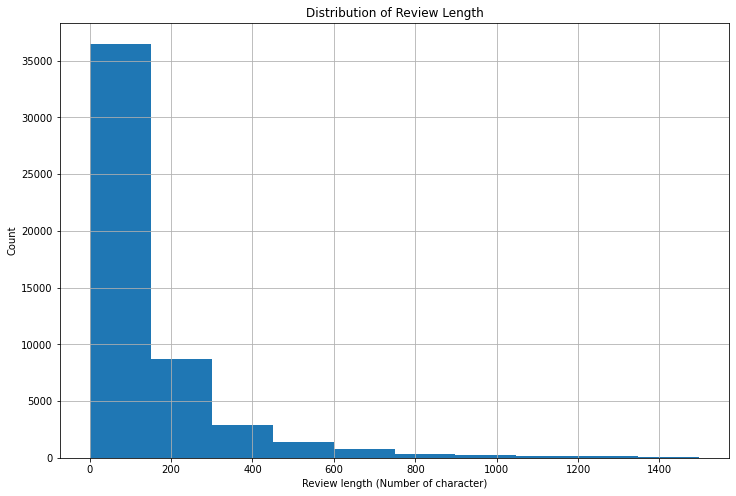

In [ ]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

### Prepare Data

In [ ]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
11511,Apple iPhone 4S 16GB (Black) - Verizon,Apple,224.77,2,the product was not required because I'm block...,2.0,0
35855,Apple iPhone 5c 8GB Unlocked GSM Smartphone - ...,Apple,115.00,5,Excellent product Ty,0.0,1
6925,"Apple iPhone 4 - 8GB, BLACK, Net 10 Ready, USE...",Apple,208.79,1,Phone works with network. But old technology d...,0.0,0
9284,Apple iPhone 4 32GB (White) - Verizon,Apple,115.00,5,"Great, Exacty as promised. Thank you very much,",0.0,1
7811,Apple iPhone 4 32GB (Black) - AT&T,Apple,99.99,5,"Bought for my great grandsons birthday, excell...",0.0,1


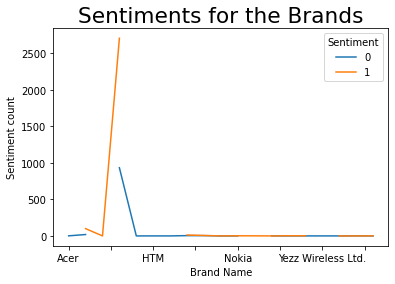

In [ ]:
df.groupby(['Brand Name','Sentiment'])['Sentiment'].count().unstack().plot(legend=True)
from matplotlib import rcParams
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9
plt.title('Sentiments for the Brands')
plt.xlabel('Brand Name')
plt.ylabel('Sentiment count')
plt.show()

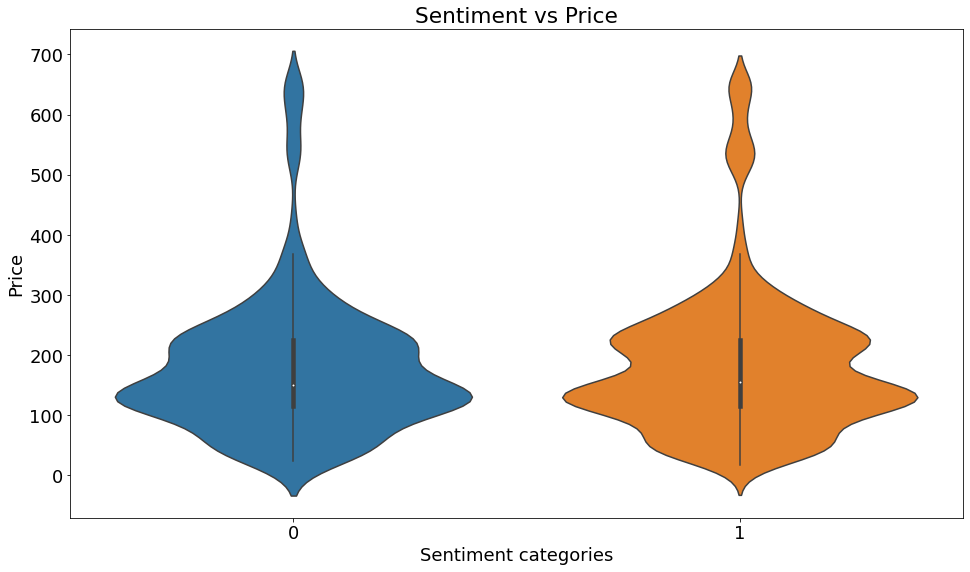

In [ ]:
#plot layout
from matplotlib import rcParams
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(df, columns = ['Sentiment', 'Price'])
senti_help = senti_help[senti_help['Price'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["Sentiment"], y=senti_help["Price"])
plt.title('Sentiment vs Price')
plt.xlabel('Sentiment categories')
plt.ylabel('Price')
plt.show()

Word Cloud

In [ ]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

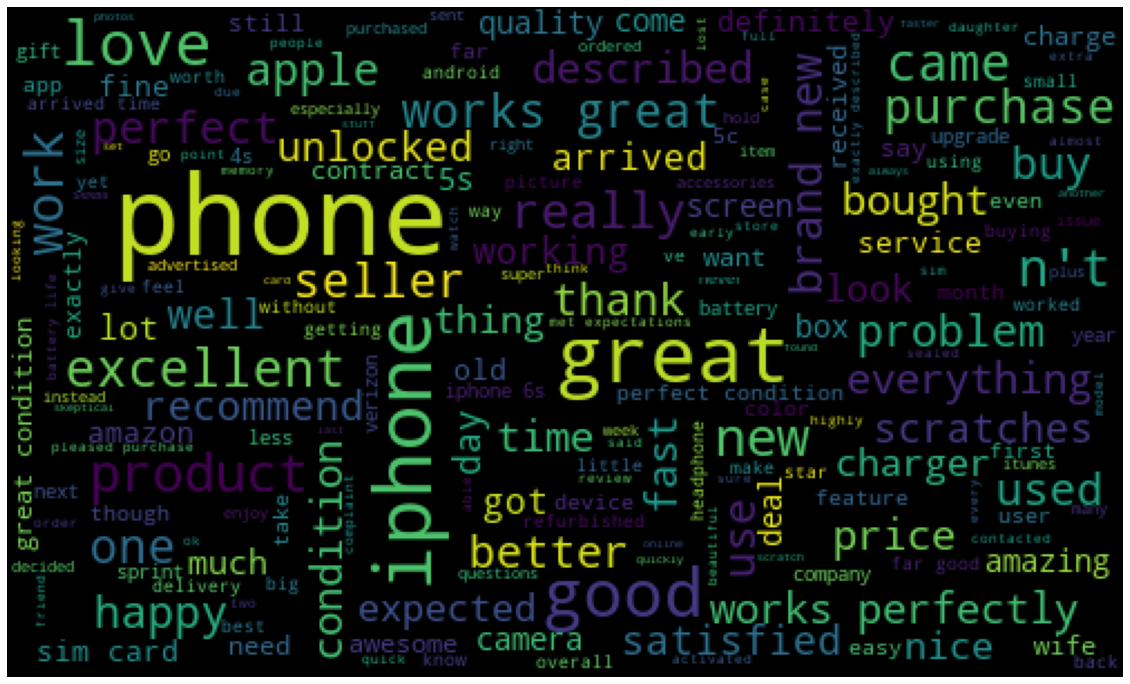

In [ ]:
create_word_cloud(brand='Apple', sentiment=1)

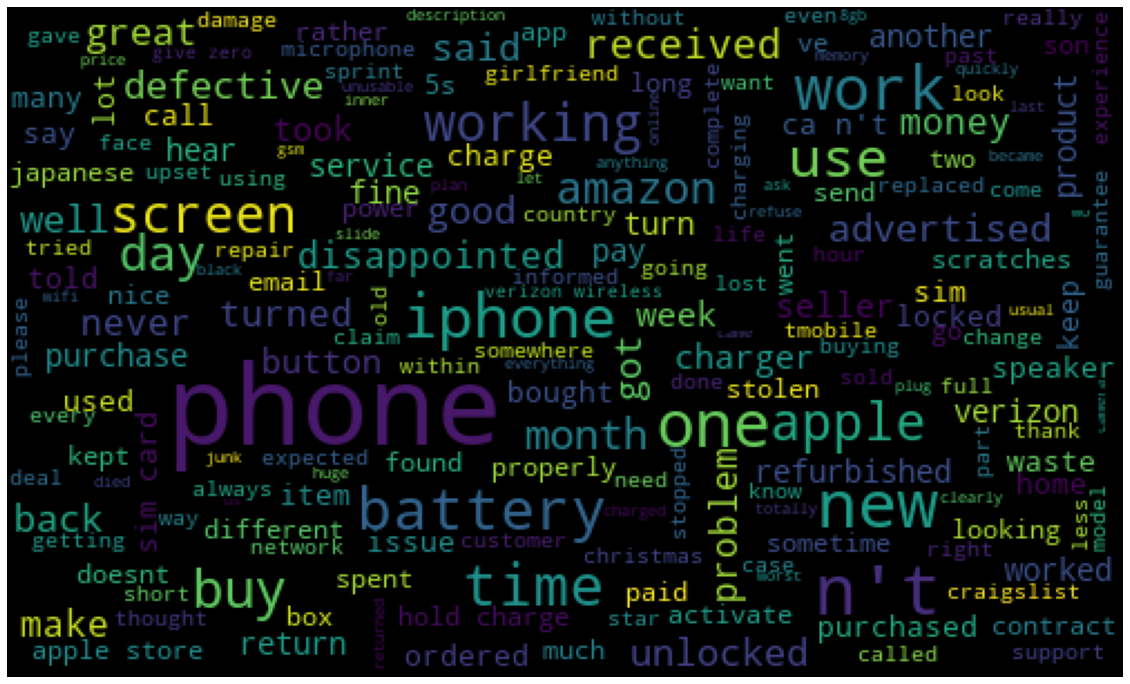

In [ ]:
create_word_cloud(brand='Apple', sentiment=0)

### Train Test Split 

In [ ]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 3447 training examples and 383 validation examples. 

Show a review in the training set : 
 The phone was in great condition. I can only find one little mark on the case. The phone has been working fine with AT&T. I'm very happy with this purchase.


---
<a id="part3"></a>
## Bag of Words

### Text Preprocessing

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [ ]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 the phone was in great condition i can only find one little mark on the case the phone has been working fine with at t i m very happy with this purchase


### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

In [ ]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 4764 

Show some feature names : 
 ['abble', 'cydia', 'hundred', 'peach', 'stickers']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MultinomialNB()

In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [ ]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9191

AUC score : 0.8790

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       108
           1       0.92      0.97      0.95       275

    accuracy                           0.92       383
   macro avg       0.92      0.88      0.90       383
weighted avg       0.92      0.92      0.92       383


Confusion Matrix : 
 [[ 85  23]
 [  8 267]]


### TfidfVectorizer with Logistic Regression

In [ ]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 1447 

Show some feature names : 
 ['00', 'recomiendo']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression()

In [ ]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())


sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'doesn' 'battery' 'locked' 'back' 'return' 'work' 'disappointing'
 'don' 'money']

Top 10 features with largest coefficients : 
['great' 'love' 'good' 'excellent' 'perfect' 'my' 'works' 'price' 'nice'
 'everything']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9191

AUC score : 0.8734

Classification report : 
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       108
           1       0.91      0.98      0.95       275

    accuracy                           0.92       383
   macro avg       0.92      0.87      0.89       383
weighted avg       0.92      0.92      0.92       383


Confusion Matrix : 
 [[ 83  25]
 [  6 269]]


### Pipeline and GridSearch

In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9269

AUC score : 0.8985

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.83      0.87       108
           1       0.94      0.96      0.95       275

    accuracy                           0.93       383
   macro avg       0.92      0.90      0.91       383
weighted avg       0.93      0.93      0.93       383


Confusion Matrix : 
 [[ 90  18]
 [ 10 265]]


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

---
<a id="part4"></a>
## Word2Vec

### Parsing Review into Sentences

In [ ]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

3443 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['the', 'phone', 'was', 'in', 'great', 'condition', 'i', 'can', 'only', 'find', 'one', 'little', 'mark', 'on', 'the', 'case', 'the', 'phone', 'has', 'been', 'working', 'fine', 'with', 'at', 't', 'i', 'm', 'very', 'happy', 'with', 'this', 'purchase']


### Creating Volcabulary List usinhg Word2Vec Model

In [ ]:
# Fit parsed sentences to Word2Vec model 

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 936 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'was', 'is', 'this']


### Averaging Feature Vectors

In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


Training set : 3447 feature vectors with 300 dimensions
Validation set : 383 feature vectors with 300 dimensions


### Random Forest Classifer

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.8903

AUC score : 0.8477

Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.75      0.79       108
           1       0.91      0.95      0.93       275

    accuracy                           0.89       383
   macro avg       0.87      0.85      0.86       383
weighted avg       0.89      0.89      0.89       383


Confusion Matrix : 
 [[ 81  27]
 [ 15 260]]


---
<a id="part5"></a>
## LSTM

In [ ]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (3447, 100)
X_test shape: (383, 100)
y_train shape: (3447, 2)
y_test shape: (383, 2)


In [ ]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128))
model1.add(LSTM(128)) 
model1.add(Dropout(0.2))
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
108/108 [===========================

In [ ]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
#print("Size of weight matrix in the output layer : ", \
      #model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)


### LSTM with Word2Vec Embedding

In [ ]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (936, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


X_train shape: (3447, 100)
X_test shape: (383, 100)
y_train shape: (3447, 2)
y_test shape: (383, 2)


In [ ]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128)) 
model2.add(Dropout(0.2))
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         280800    
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                                 
Total params: 500,706
Trainable params: 500,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
108/108 [=============================

Thankyou.